# Analyzing On Time Preformance Statistics 

1. Conduct Exploratory Data Analysis on On time preformance metrics accross all Airlines between any two routes 
2. Develop a robost pipeline to extract useful metrics and novel network attributes 
3. Filter On Time data to current network level nodes
4. Clean the data and conduct data imputation 
5. Develop a pipeline to fit a density estimate and extract key metrics
6. Define statistical processes to model the probability of delay over time for a single route

Data Extraction and Preprocessing 

Pull Data --> CLean Data --> Filter Data to match edge table --> Develop r.v.s --> Determine optimal bw --> Apply KDE fit for all r.v.s --> 



In [1]:
# import relevant libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in airline on time preformance data
on_time_data = pd.read_csv('Database/August 2018 Nationwide.csv')
# generate new column for the foreign key (route- origin-destination key)
on_time_data['citypair'] = on_time_data['ORIGIN'].astype(str) + '-' + on_time_data['DEST']   # dataset 4
# read in the dataset - DOT airline on time performance statistics
on_time_data_carriers = pd.read_csv('Database/Air Carriers.csv')
# extract corresponding code for southwest airlines
sw_carrier_code = on_time_data_carriers.loc[on_time_data_carriers['Description'] == "Southwest Airlines Co.: WN", 'Code']
print(sw_carrier_code) 

362    19393
Name: Code, dtype: int64


In [3]:
# clean the data
on_time_data = on_time_data.drop(['OP_CARRIER_FL_NUM', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY'], axis=1)

on_time_data

,FL_DATE,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,ACTUAL_ELAPSED_TIME,citypair
0,8/1/2018,9.0,44.0,0,377.0,JFK-PHX
1,8/1/2018,29.0,53.0,0,309.0,PHX-EWR
2,8/1/2018,0.0,0.0,0,177.0,CLE-DFW
3,8/1/2018,44.0,43.0,0,303.0,SJU-DFW
4,8/1/2018,0.0,0.0,0,175.0,AUS-MIA
...,...,...,...,...,...,...
701347,8/31/2018,0.0,0.0,0,150.0,SLC-DFW
701348,8/31/2018,0.0,12.0,0,226.0,TUS-ORD
701349,8/31/2018,2.0,0.0,0,182.0,DFW-LAX
701350,8/31/2018,0.0,0.0,0,304.0,LAX-MCO


## Part I: Exploratory Data Analysis and Data Cleaning

In [4]:
# import edge table data and filter on time statistics data records accordingly

edge_data = pd.read_csv('Database\FINAL_EDGE_TABLE.csv')
list_of_routes = edge_data['citypair'].to_list()

fltrd_on_time = on_time_data[on_time_data['citypair'].isin(list_of_routes)]
unique_city_pairs = len(set(fltrd_on_time['citypair'].to_list()))

# check the amount of data accounted for   There are 1240 original edges 
print('amount of data in on time stats', unique_city_pairs)   # missing data for 1240 - 1211 routes 
print('Missing Data for', 1240 - 1211, 'routes;', 'proportion of missing data:', (1240 - 1211)/1240 )

amount of data in on time stats 1211
Missing Data for 29 routes; proportion of missing data: 0.02338709677419355


In [5]:
edge_data.isna().sum()

Unnamed: 0                              0
Unnamed: 0.1                            0
citypair                                0
sum_departures_performed                0
sum_departures_scheduled                0
passengers                              0
seats                                   0
avg_fuel_price                          0
avg_stock_price                         0
total_operating_expense                 0
revenue                                 0
Aircraft_Unit_Cost ($ millions USD)     0
Aircraft_Inverse_Age 1/age (1/yrs)      0
Number_of_Cancellations                 0
Proportion of Seats filled              0
Aircraft Age (yrs)                      0
Origin_Airport_Code                     0
Destination_Airport_Code                0
origin_airport_type                     0
origin_lat                              0
origin_long                             0
origin_city                             0
dest_airport_type                       0
dest_lat                          

In [6]:
# function to filter main dataframe by citypair id

from tqdm import tqdm
from joblib import Parallel, delayed

def filter_ontime_data(citypair_id): 
    # NOTE: citypair_id --> string-64-bit for the citypair key 
    df = fltrd_on_time.loc[fltrd_on_time['citypair'] == citypair_id]
    return df
# test the number of entries in each dataframe filter
df_lengths = np.zeros(len(list_of_routes))
for i in tqdm(range(len(list_of_routes))):
    df_lengths[i] = len(filter_ontime_data(list_of_routes[i]))

100%|██████████| 1240/1240 [00:46<00:00, 26.86it/s]


In [7]:
# compile data together to get aggregate table

on_time_fin = fltrd_on_time.groupby('citypair').agg({'DEP_DELAY_NEW':'mean','ARR_DELAY_NEW':'mean', 'CANCELLED':'mean'})
on_time_fin = on_time_fin.reset_index()
# merge together the data
edge_data = edge_data.merge(on_time_fin, how='left')
# check null values 
nan_count = edge_data.isna().sum()
print(nan_count)
# there are once again 29 missing data points # we will replace these values by 

Unnamed: 0                              0
Unnamed: 0.1                            0
citypair                                0
sum_departures_performed                0
sum_departures_scheduled                0
passengers                              0
seats                                   0
avg_fuel_price                          0
avg_stock_price                         0
total_operating_expense                 0
revenue                                 0
Aircraft_Unit_Cost ($ millions USD)     0
Aircraft_Inverse_Age 1/age (1/yrs)      0
Number_of_Cancellations                 0
Proportion of Seats filled              0
Aircraft Age (yrs)                      0
Origin_Airport_Code                     0
Destination_Airport_Code                0
origin_airport_type                     0
origin_lat                              0
origin_long                             0
origin_city                             0
dest_airport_type                       0
dest_lat                          

In [8]:
# fill in null values with the mean
edge_data['DEP_DELAY_NEW'].fillna(value=0, inplace=True)
edge_data['ARR_DELAY_NEW'].fillna(value=0, inplace=True)
edge_data['CANCELLED'].fillna(value=0, inplace=True)

In [9]:
edge_data.isna().sum()

Unnamed: 0                              0
Unnamed: 0.1                            0
citypair                                0
sum_departures_performed                0
sum_departures_scheduled                0
passengers                              0
seats                                   0
avg_fuel_price                          0
avg_stock_price                         0
total_operating_expense                 0
revenue                                 0
Aircraft_Unit_Cost ($ millions USD)     0
Aircraft_Inverse_Age 1/age (1/yrs)      0
Number_of_Cancellations                 0
Proportion of Seats filled              0
Aircraft Age (yrs)                      0
Origin_Airport_Code                     0
Destination_Airport_Code                0
origin_airport_type                     0
origin_lat                              0
origin_long                             0
origin_city                             0
dest_airport_type                       0
dest_lat                          

In [44]:
# save the file again as updated csv
edge_data.to_csv('Database/FINAL_EDGE_TABLE.csv')

### Distribution of Cancellation Probabilities, Avg Departure Delay Time, Avg Arrival Delay Time

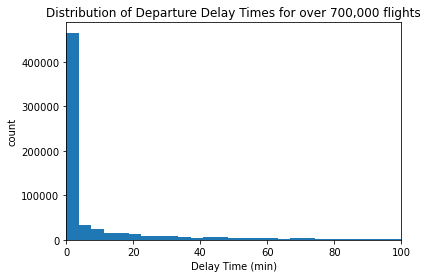

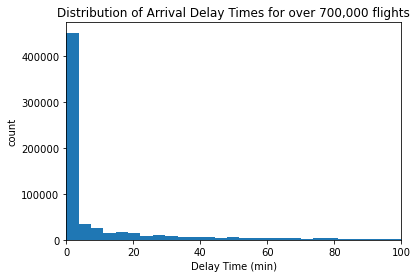

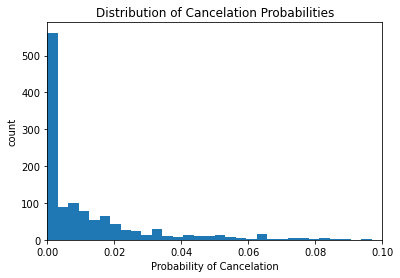

In [10]:
delay_vals = on_time_data['DEP_DELAY_NEW'].to_list()
arrival_vals = on_time_data['ARR_DELAY_NEW'].to_list()
cancel_vals = on_time_fin['CANCELLED'].to_list()


plt.hist(delay_vals,bins=500)
plt.title('Distribution of Departure Delay Times for over 700,000 flights')
plt.xlabel('Delay Time (min)')
plt.ylabel('count')
plt.xlim([0,100])
plt.show()

plt.hist(arrival_vals,bins=500)
plt.title('Distribution of Arrival Delay Times for over 700,000 flights')
plt.xlabel('Delay Time (min)')
plt.ylabel('count')
plt.xlim([0,100])
plt.show()

plt.hist(cancel_vals,bins=50)
plt.title('Distribution of Cancelation Probabilities')
plt.xlabel('Probability of Cancelation')
plt.ylabel('count')
plt.xlim([0,0.10])
plt.show()

## Part II: Kernel Density Estimation

Define the following random variables for each airline route i $\in$ {list_of_routes}

1. $D_{i}$ ~ departure delay time  (continuous r.v.) ~ KDE distribution
2. $A_{i}$ ~ arrival delay time  (continuous r.v.) ~ KDE distribution
3. $T_{i}$ ~ duration time (continuous r.v.) ~ KDE distribution
4. $C_{i}$ ~ cancellation (discrete binomial r.v.) ~ $ \binom{n}{x}  p^{x} *  (1 - p)^{n-x}$, where p ~ probability of a flight on route i being canceled



### Methods for Optimal Bandwidth Determination for KDEs

Bandwidth is an important parameter to calculate for Kernel Density Estimation. A large Bandwidth value can produce a non-parametric based distribution with high bias or oversmoothing, whereas a small Bandwidth has a larger variance or undersmoothing.

Methodology : 

We consider the following method for Optimal Bandwidth Extraction:

### Maximum Likelihood Cross Validation 

Consider the following Objective function given a Kernel Function

### $ MLCV_{max} = \frac{1}{n} \sum_{i=1}^{n} log[\sum_{x_j} K(\frac{x_j - x_i}{h})] - log[(n-1)h]$


We wish to select a bandwidth value which maximizes this objective function

In [11]:
def optimal_bw(data_vec):

    def obj_func_2(data_vec, h, x):
        '''
        Goal: return objective function value of the log likelihood probabilities
        Parameters:
            data_vec (python list-like object): contains the sample x_i data 
            h (float-64 bit): bandwidth value to test
            x (python list-like object): support of r.v. to evaluate KDE over
        '''

        # extract total no. of data points
        N = len(data_vec)
        M = len(x)

        vec2 = data_vec.copy()
        vec2.sort()

        kde_estimates = np.zeros([M, N])

        for i in range(N):
            for j in range(M):
                if vec2[i] == x[j]:
                    kde_estimates[j][i] = 0
                else:
                    iterate = (x[j] - vec2[i]) / h
                    kernel_estimate = 1/(np.sqrt(2*np.pi)) * \
                        (np.e**(-0.5 * (iterate)**2))
                    kde_estimates[j][i] = kernel_estimate

        log_sum = np.log(np.sum(kde_estimates, axis=0))

        filter_term = np.log((N-1)*h)

        rslt_mean = np.average(log_sum - filter_term)

        return rslt_mean

    bandwidths = list(np.arange(0.01, 0.4, 0.001))
    obj_function_vals = []
    x = np.arange(min(data_vec)-0.7, max(data_vec)+0.7)

    for bw in bandwidths:
        obj_function_vals.append(obj_func_2(data_vec, bw, x))

    max_val = max(obj_function_vals)
    filtered = [x for x in obj_function_vals if np.abs(max_val - x) < 0.035]
    ind = obj_function_vals.index(max_val)
    h = bandwidths[ind]

    return h

In [12]:
on_time_data

,FL_DATE,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,ACTUAL_ELAPSED_TIME,citypair
0,8/1/2018,9.0,44.0,0,377.0,JFK-PHX
1,8/1/2018,29.0,53.0,0,309.0,PHX-EWR
2,8/1/2018,0.0,0.0,0,177.0,CLE-DFW
3,8/1/2018,44.0,43.0,0,303.0,SJU-DFW
4,8/1/2018,0.0,0.0,0,175.0,AUS-MIA
...,...,...,...,...,...,...
701347,8/31/2018,0.0,0.0,0,150.0,SLC-DFW
701348,8/31/2018,0.0,12.0,0,226.0,TUS-ORD
701349,8/31/2018,2.0,0.0,0,182.0,DFW-LAX
701350,8/31/2018,0.0,0.0,0,304.0,LAX-MCO


Strategy for extracting KDE distribution estimates

Extract data vector --> optimal bw determination --> KDE fit --> extract distribution estimate --> sample r.v.s

In [14]:
# create a general function to find optimal parameter and apply KDE fit

from scipy.stats import gaussian_kde, norm

def kde_dist_fit(citypair, metric):
    # parameter: citypair key word 
    # parameter: metric to extract estimate for : {DEP_DELAY_NEW, ARR_DELAY_NEW}

    # x ~ vector of data based on the following
    # filter data given citypair key and metric argument 
    fltrd = on_time_data.loc[on_time_data['citypair'] == citypair]
    x = fltrd[metric].to_list()

    # fix h based on MLCV

    h = optimal_bw(x)

    # fix the kde model fit
    model = gaussian_kde(x, h)
    std = np.std(x)

    # get x value of estimates 
    x_vals = np.arange(min(x) - std*2 , max(x) + 2*std, 0.001)
    rslts = model.evaluate(x_vals)

    return model, rslts, x_vals


In [15]:
on_time_data

,FL_DATE,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,ACTUAL_ELAPSED_TIME,citypair
0,8/1/2018,9.0,44.0,0,377.0,JFK-PHX
1,8/1/2018,29.0,53.0,0,309.0,PHX-EWR
2,8/1/2018,0.0,0.0,0,177.0,CLE-DFW
3,8/1/2018,44.0,43.0,0,303.0,SJU-DFW
4,8/1/2018,0.0,0.0,0,175.0,AUS-MIA
...,...,...,...,...,...,...
701347,8/31/2018,0.0,0.0,0,150.0,SLC-DFW
701348,8/31/2018,0.0,12.0,0,226.0,TUS-ORD
701349,8/31/2018,2.0,0.0,0,182.0,DFW-LAX
701350,8/31/2018,0.0,0.0,0,304.0,LAX-MCO


Text(0.5, 1.0, 'KDE Fit to the Proofreader Accuracy Data w/ Optimal Bandwidth h')

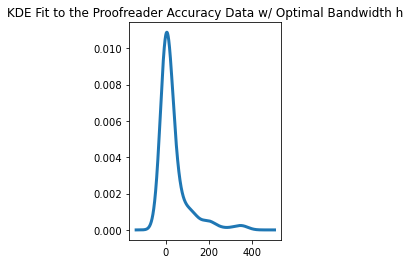

In [16]:

plt.subplot(121)
# plot KDE estimate
model_phx_ewr_dep_delay, y_1, x_1 = kde_dist_fit('PHX-EWR','DEP_DELAY_NEW')
plt.plot(x_1, y_1, linewidth=3)
plt.title('KDE Fit to the Proofreader Accuracy Data w/ Optimal Bandwidth h')